In [1]:
%reset -f
%load_ext autoreload
%autoreload 2
#matplotlib figure size
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
from mri_project.custom_imports import *
from mri_project.utility import dfe, write_areas
from flatten_dict import flatten
__spec__ = 'Mardas'

/home/bzr0014/miniconda3/envs/mri_project/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/bzr0014/miniconda3/envs/mri_project/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/bzr0014/miniconda3/envs/mri_project/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/bzr0014/miniconda3/envs/mri_project/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/bzr0014/miniconda3/envs/mri_projec

In [2]:
identifier = "a896d"
root = "../data/images_with_predictions_v04"
files = glob.glob(root+"/*data")
file = np.random.choice(files)

In [11]:
rm -r $root/mri_analysis_behnam_$identifier

In [4]:
def get_write_dir(id_):
    id_ = id_.replace('../data/mri_analysis', f'/mri_analysis_behnam_{identifier}')\
        .replace(" Set#", '/Set').replace(' ', '__').replace(':', "_")\
        .replace('..', 'blahblah').replace('.', '_').replace('blahblah', '..')
    d, f, e = dfe(id_)
    return root+d, f, e

In [5]:
import scipy.ndimage
import imageio

In [17]:
from uuid import uuid4
predicted = []
traced = []
def rescale(x):
    return np.uint8((x-x.min())/(x.max()-x.min())*255)
def map_fun(file, index=-1):
    # print(index, file)
    # if index % 40 == 0:
    #     print(f"{index}:{file}")
    data = joblib.load(file)
    # data.predicted = data.predicted_postprocessed
    data.get_traced_contours(90)
    data.get_predicted_contours(90)
    data.get_contour_areas()
    data.get_contour_centers() 
    dic = {
        'raw': data.raw_image,
        'traced': data.traced_image,
        'predicted': data.predicted,
        'traced_lever_arms_90': data.traced_lever_arm_images[90]+150,
        'predicted_lever_arms_90': data.predicted_lever_arm_images[90]+150,
    }
    dr, f, e = get_write_dir(data.id)
    print(dr)
    if not os.path.exists(dr):
        os.makedirs(dr)
    for k, v in dic.items():
        # plt.imshow(v)
        # plt.axis('off')
        # plt.savefig(f"{dr}/{k}.png", dpi=150, bbox_inches=0)
        f_name = f"{dr}/{k}_{f}.png"
        # print(f_name)
        v2 = rescale(v)
        imageio.imsave(f_name, v2)
        
    traced_area_image = write_areas(
        data.traced_multilabel_mask, 
        data.traced_features['center'].values(),
        data.traced_features['area'].values(),
        color=10
    )
    f_name = f"{dr}/traced_area_{f}.png"
    imageio.imsave(f_name, rescale(traced_area_image))
    predicted_area_image = write_areas(
        data.predicted, 
        data.predicted_features['center'].values(),
        data.predicted_features['area'].values(),
        color=10
    )
    f_name = f"{dr}/predicted_area_{f}.png"
    imageio.imsave(f_name, rescale(predicted_area_image))
    
    trace_data = pd.DataFrame(flatten(data.traced_features)).transpose()
    trace_data.to_csv(dr+f"/traced_features_{f}.csv")
    pred_data = pd.DataFrame(flatten(data.predicted_features)).transpose()
    trace_data.to_csv(dr+f"/predicted_features_{f}.csv")
    plt.imshow(v2)
    return data.id, {'has_good_prediction': data.has_good_prediction(), 
                     'traced': data.traced_features, 'predicted': data.predicted_features
                    }

0 ../data/images_with_predictions_v04/1-CO5-3:16RepPreRaw.data
../data/images_with_predictions_v04/mri_analysis_behnam_a896d/2_Multigroup/Set2/Control/Control__-__Pre/Male/Subject__M5/Raw


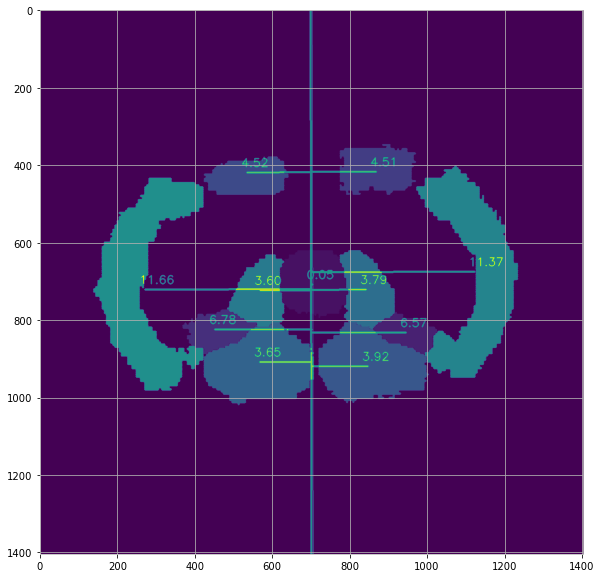

In [18]:
for index, file in enumerate(files):
    if index % 40 == 0:
        print(index, file)
    map_fun(file)
    break

In [19]:
!ls ../data/images_with_predictions_v04/mri_analysis_behnam_a896d/2_Multigroup/Set2/Control/Control__-__Pre/Male/Subject__M5/Raw

predicted_1-CO5-3_16RepPreRaw_jpg.png
predicted_area_1-CO5-3_16RepPreRaw_jpg.png
predicted_features_1-CO5-3_16RepPreRaw_jpg.csv
predicted_lever_arms_90_1-CO5-3_16RepPreRaw_jpg.png
raw_1-CO5-3_16RepPreRaw_jpg.png
traced_1-CO5-3_16RepPreRaw_jpg.png
traced_area_1-CO5-3_16RepPreRaw_jpg.png
traced_features_1-CO5-3_16RepPreRaw_jpg.csv
traced_lever_arms_90_1-CO5-3_16RepPreRaw_jpg.png


In [20]:
import dask.bag as db

In [ ]:
res = db.from_sequence(files).map(map_fun).compute()

In [ ]:
from flatten_dict import flatten

In [ ]:
res_fl = flatten(dict(res))

In [78]:
df = pd.DataFrame(res_fl)
df = df.transpose().reset_index()
df['value'] = df[0].combine(df[1], lambda x, y: x if x == y else (x, y))
df = df.drop([0, 1], axis=1)
df.columns = ['id', 'type', 'metric', 'muscle', 'value']

In [79]:
df.head(20)

,id,type,metric,muscle,value
0,../data/mri_analysis/2.Multigroup Set#2/Contro...,has_good_prediction,NaN,NaN,True
1,../data/mri_analysis/2.Multigroup Set#2/Contro...,traced,lever_arm_90,1.0,0.39448
2,../data/mri_analysis/2.Multigroup Set#2/Contro...,traced,lever_arm_90,4.0,3.73311
3,../data/mri_analysis/2.Multigroup Set#2/Contro...,traced,lever_arm_90,5.0,2.6059
4,../data/mri_analysis/2.Multigroup Set#2/Contro...,traced,lever_arm_90,6.0,1.96799
5,../data/mri_analysis/2.Multigroup Set#2/Contro...,traced,lever_arm_90,7.0,2.78732
6,../data/mri_analysis/2.Multigroup Set#2/Contro...,traced,lever_arm_90,8.0,4.88394
7,../data/mri_analysis/2.Multigroup Set#2/Contro...,traced,lever_arm_90,9.0,5.16631
8,../data/mri_analysis/2.Multigroup Set#2/Contro...,traced,lever_arm_90,10.0,10.1741
9,../data/mri_analysis/2.Multigroup Set#2/Contro...,traced,lever_arm_90,11.0,9.80511


In [80]:
df.to_csv(root+f"/all_features_{identifier}.csv", index=False)

In [83]:
df_piv = df.pivot(index=['id', 'muscle'], columns=['type', 'metric'])['value'].reset_index()
df_piv.to_csv(root+f"/all_features_pivot_{identifier}.csv", index=False)

In [84]:
df_piv.sample(10)

type                                                   id muscle  \
metric                                                             
6474    ../data/mri_analysis/3.Contiguous Set#1/Weight...    6.0   
771     ../data/mri_analysis/1.Multigroup Set#1_DONE/C...   11.0   
8727    ../data/mri_analysis/4.Contiguous Set#2/Weight...    7.0   
6462    ../data/mri_analysis/3.Contiguous Set#1/Weight...    4.0   
3059    ../data/mri_analysis/2.Multigroup Set#2/Contro...    NaN   
67      ../data/mri_analysis/1.Multigroup Set#1_DONE/C...    9.0   
9222    ../data/mri_analysis/4.Contiguous Set#2/Weight...    NaN   
2569    ../data/mri_analysis/2.Multigroup Set#2/Contro...    1.0   
3612    ../data/mri_analysis/2.Multigroup Set#2/Weight...   10.0   
3317    ../data/mri_analysis/2.Multigroup Set#2/Contro...    NaN   

type   has_good_prediction       traced           \
metric                 NaN lever_arm_90     area   
6474                   NaN      1.89364  5.54256   
771                    NaN      10.8697  35.7103   
8727                   NaN      2.66181  7.28476   
6462                   NaN      4.50282  11.6799   
3059                  True          NaN      NaN   
67                     NaN      9.69257  65.9214   
9222                  True          NaN      NaN   
2569                   NaN     0.106308  17.0251   
3612                   NaN      10.5348  18.3268   
3317                  True          NaN      NaN   

type                                               predicted           \
metric                                   center lever_arm_90     area   
6474    (1102.990476190476, 1016.2809523809524)      2.06991  8.48063   
771     (319.16751269035535, 595.4433164128595)      10.9027  47.5999   
8727      (861.806916426513, 975.3890489913545)      2.56401  11.5266   
6462    (1258.8376623376623, 355.7077922077922)      3.53252  17.7629   
3059                                        NaN          NaN      NaN   
67        (527.4207920792079, 697.003300330033)      8.93299  83.1721   
9222                                        NaN          NaN      NaN   
2569     (702.5422740524781, 697.5481049562683)     0.107527  21.6611   
3612    (1112.6560606060607, 708.1833333333333)      10.5855  35.8917   
3317                                        NaN          NaN      NaN   

type                                             
metric                                   center  
6474    (1109.7071651090343, 992.7383177570093)  
771     (318.34383202099735, 604.1811023622047)  
8727     (874.5822102425876, 985.1212938005391)  
6462    (1200.7014218009479, 353.2148499210111)  
3059                                        NaN  
67       (551.6197916666666, 725.0677083333334)  
9222                                        NaN  
2569     (709.2457420924575, 702.0486618004866)  
3612    (1114.4867967853043, 691.8231917336395)  
3317                                        NaN

In [19]:
data_ = joblib.load(file)

In [20]:
data_.traced_features

{'lever_arm_90': {1: 0.5355725220767497,
  2: 5.883331604124725,
  3: 5.677866987446541,
  4: 3.29117041380609,
  5: 4.940111045763578,
  6: 4.239210289783471,
  7: 4.015204155362468,
  8: 3.93390214042855,
  9: 3.2179497417458807,
  10: 11.422257206039363,
  11: 11.454312245940478},
 'area': {1: 12.057417322140703,
  2: 4.00848994939814,
  3: 3.1356262072105823,
  4: 5.412709953657803,
  5: 5.615411167661813,
  6: 22.18366492608016,
  7: 23.462298308619946,
  8: 8.787024184604991,
  9: 9.492439097832715,
  10: 30.45145085597198,
  11: 28.679284082813734},
 'center': {1: array([707.92922374, 707.56392694]),
  2: array([905.46116505, 821.77184466]),
  3: array([478.8852459, 840.6557377]),
  4: array([809.12886598, 431.3556701 ]),
  5: array([505.4       , 434.72608696]),
  6: array([844.9254386 , 897.65570175]),
  7: array([540.352657  , 906.57971014]),
  8: array([833.35474006, 723.01223242]),
  9: array([569.46368715, 730.27932961]),
  10: array([1109.59655597,  677.80196802]),
  11: 

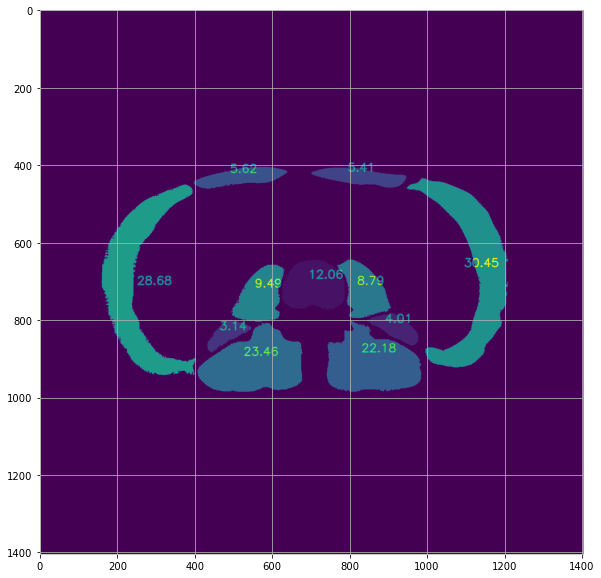

In [45]:
tmp_ = write_areas(
    data_.traced_multilabel_mask, 
    data_.traced_features['center'].values(),
    data_.traced_features['area'].values()
)
plt.imshow(tmp_)

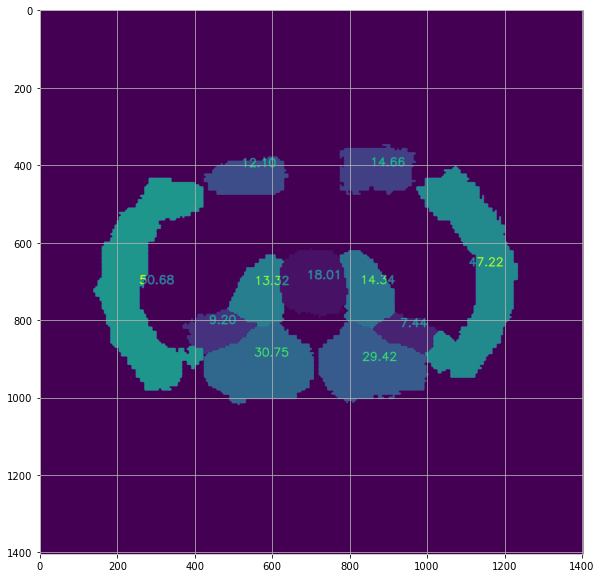

In [47]:
tmp_ = write_areas(
    data_.traced_multilabel_mask, 
    data_.traced_features['center'].values(),
    data_.traced_features['area'].values()
)
tmp_ = write_areas(
    data_.predicted, 
    data_.predicted_features['center'].values(),
    data_.predicted_features['area'].values()
)
plt.imshow(tmp_)